In [2]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
source("../../../../src/tools.R")
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

In [26]:
SVM <- read.table("SVM_validation.csv",sep=',',header=T)
list_models <- grep(list.files(path="Prognosis"), pattern='.R|.csv|neural_network', inv=T, value=T)
df_w_all <-NULL
for (l in list_models){
    
  tmp <- cbind(read.table(paste("Prognosis",l,sep="/")),SVM_optimized=SVM[,substr(l,1,nchar(l)-4)])
#   tmp <- read.table(paste("Prognosis",l,sep="/")  )
  tmp$RFS_1_20 <- NULL
  if(tmp[1,]$RFX_==0.5){
      tmp$RFX_ <- median(as.matrix(tmp[,!(colnames(tmp) == "RFX_")]))
      }
  tmp$model <- substr(l,1,nchar(l)-4)
  
  assign(substr(l,1,nchar(l)-4),melt(tmp,id='model')) 
  df_w_all <- rbind(df_w_all,get(substr(l,1,nchar(l)-4)))
}
colnames(df_w_all) <- c('model','algorithm','CI_test')
model_medians<-c()
df_w_all$model<-factor(df_w_all$model,levels=substr(list_models,1,nchar(list_models)-4))
df_w_all$median <- 0
for( model in levels(df_w_all$model)){
   df_w_all[df_w_all$model==as.character(model),]$median <- median(df_w_all$CI_test[df_w_all$model==as.character(model)],na.rm=T)
}
df_w_all <- df_w_all[order(df_w_all$median,decreasing=T),]
df_w_all$model<-factor(df_w_all$model,levels=unique(df_w_all$model))

model_medians <- df_w_all[,c("model","median")][!duplicated(df_w_all[,c("model","median")]), ]

In [27]:
top <- model_medians[model_medians$median>0.68,]
worst <- model_medians[model_medians$median<0.64,]
df_w_top <- df_w_all[is.element(df_w_all$model,unique(top$model)),]
df_w_worst <- df_w_all[is.element(df_w_all$model,unique(worst$model)),]

# All Models

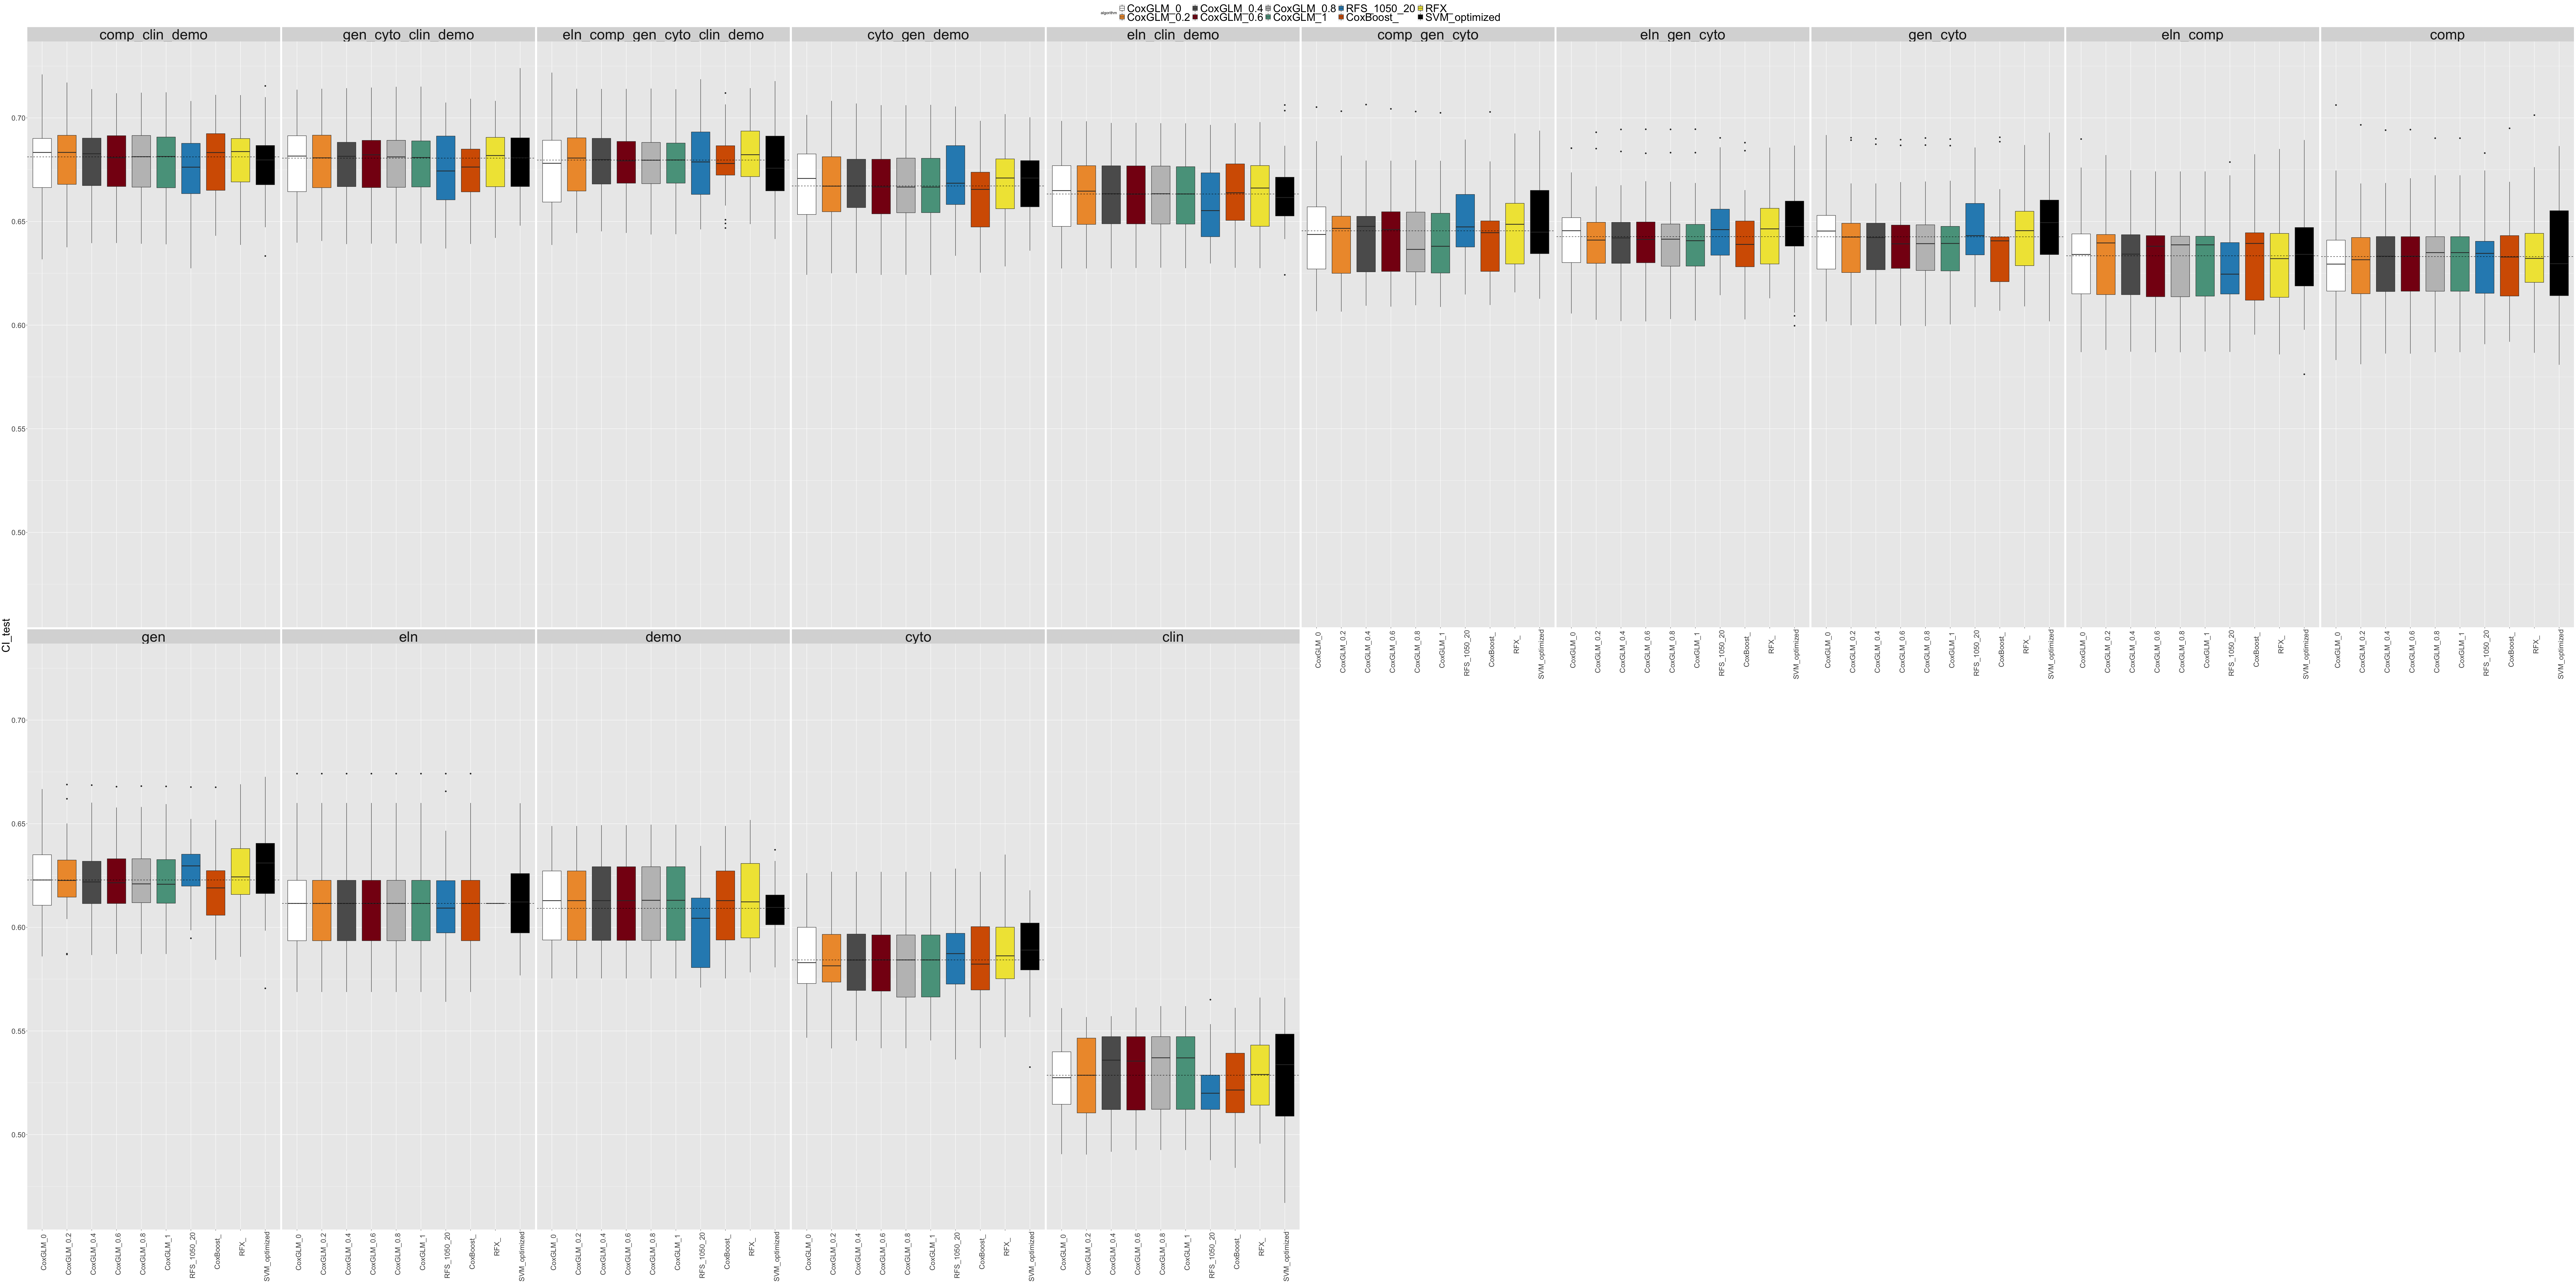

In [28]:
# For ordering Facets by decreasing order :
# pdf(file="../graphs/Prognosis_results/all_models.pdf")
set_notebook_plot_size(100,50)

ggplot(df_w_all,aes(x=algorithm,y=CI_test)) +
    geom_boxplot(aes(fill = algorithm), notch=F)+
    facet_wrap( ~ model, ncol=10) +
    geom_hline(data = model_medians, aes(yintercept = median), linetype = 2)+
    theme(legend.position="top",strip.text = element_text(size=20),axis.text.x = element_text(size=20,angle = 90, hjust = 0.8,vjust=0.8),axis.text.y =element_text(size=20),legend.text=element_text(size=30),axis.title.y =element_text(size=30)) +
    xlab("") + scale_fill_manual(values = c("white","#EE9937","#5C5C5C","#870C14","#BFBFBF","#59A08B","#2b8cbe","#D55E00","#F0E442","#000000","#a6bddb","mistyrose4"))+ theme(strip.text.x = element_text(size = 40))
# dev.off()

# TOP MODELS:

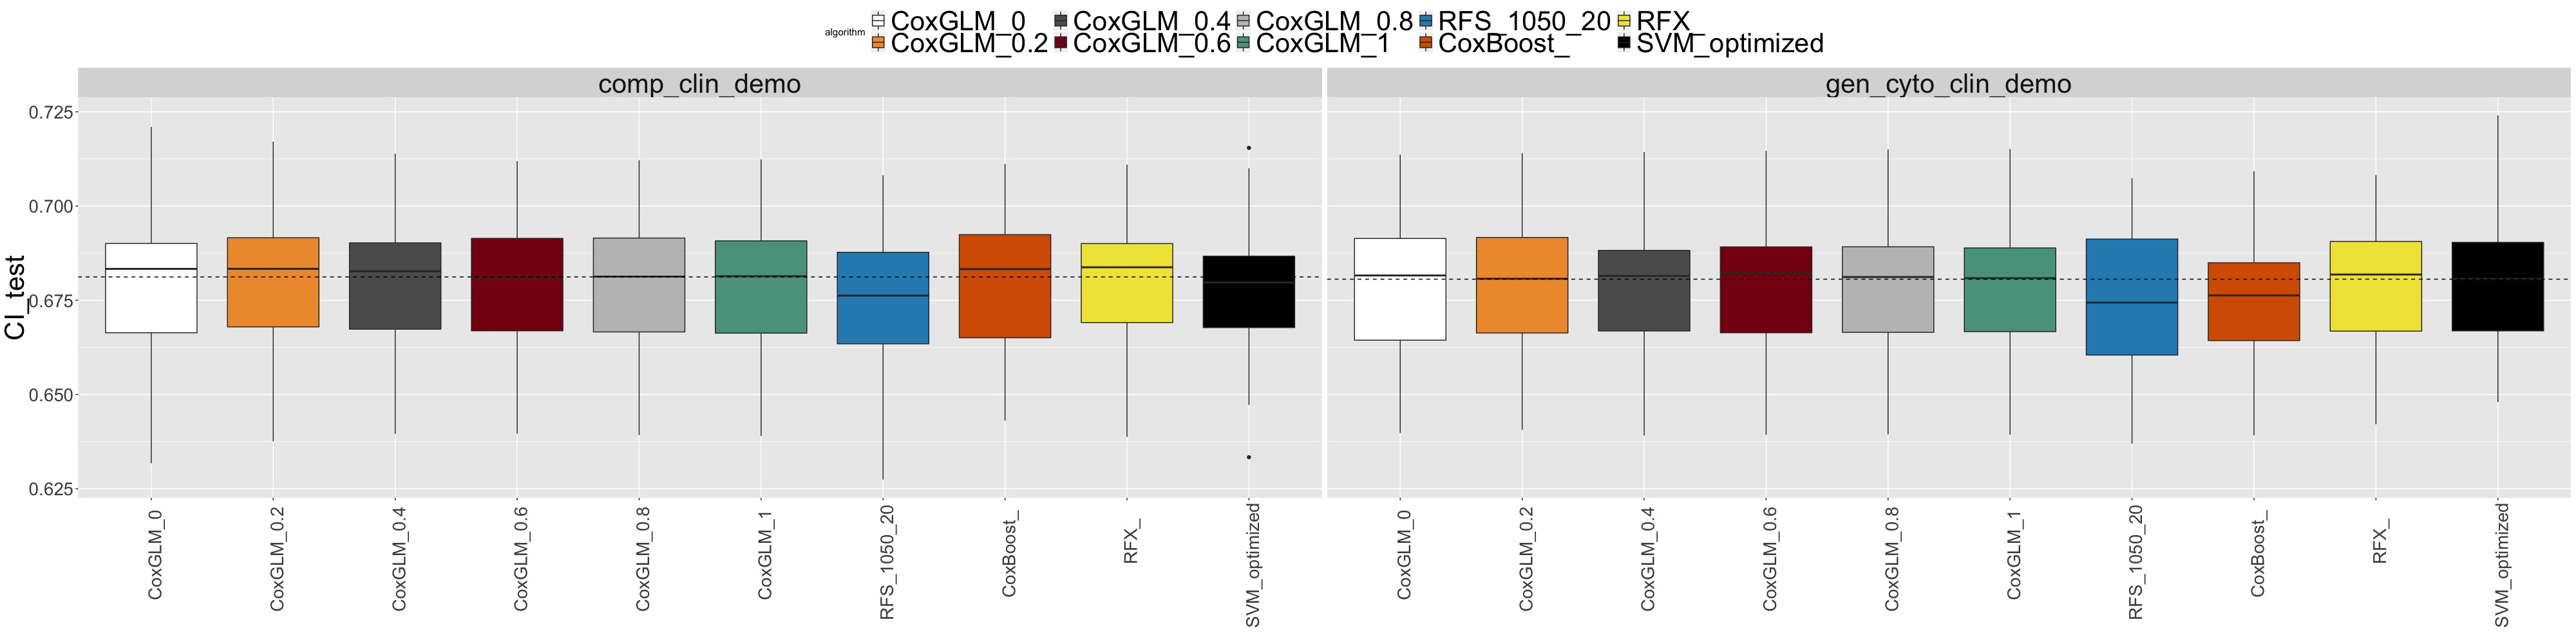

In [32]:
set_notebook_plot_size(40,10)
ggplot(df_w_top,aes(x=algorithm,y=CI_test)) +
    geom_boxplot(aes(fill = algorithm), notch=F)+
    #scale_fill_manual(values = c('#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69'))+
    facet_wrap( ~ model, ncol=2) +
    geom_hline(data = top, aes(yintercept = median), linetype = 2)+
    theme(legend.position="top",strip.text = element_text(size=20),axis.text.x = element_text(size=20,angle = 90, hjust = 0.8,vjust=0.8),axis.text.y =element_text(size=20),legend.text=element_text(size=30),axis.title.y =element_text(size=30)) +
    xlab("") + scale_fill_manual(values = c("white","#EE9937","#5C5C5C","#870C14","#BFBFBF","#59A08B","#2b8cbe","#D55E00","#F0E442","#000000","#a6bddb","mistyrose4"))+ theme(strip.text.x = element_text(size = 30))

# WORST MODELS:

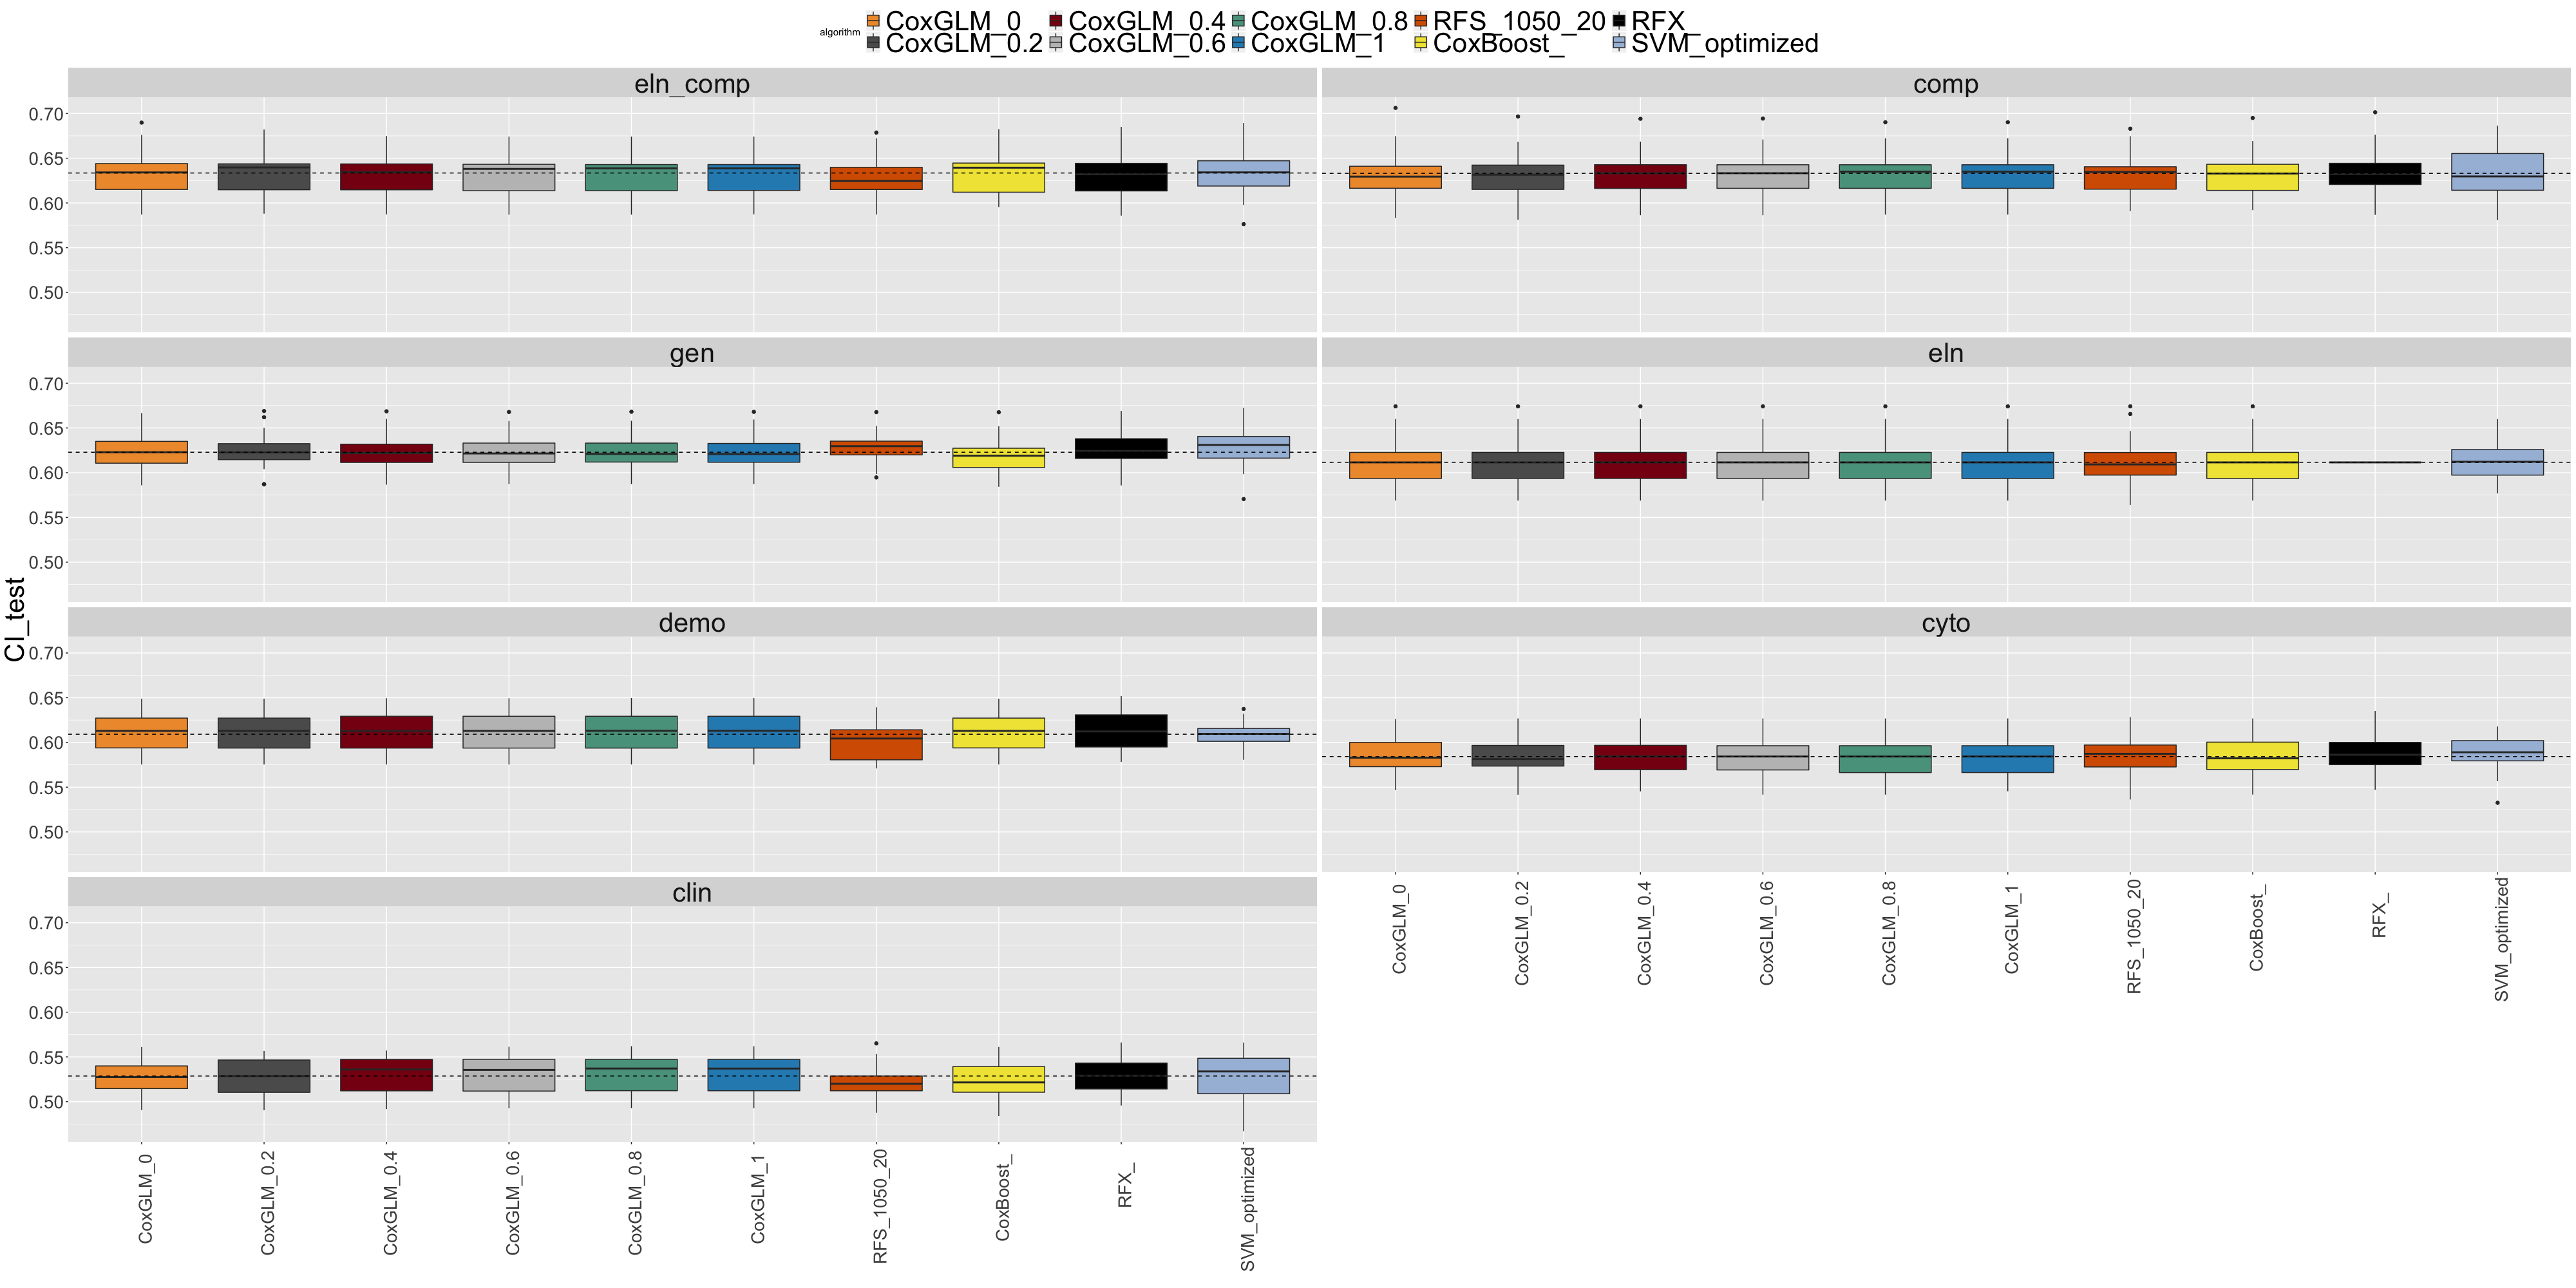

In [29]:
set_notebook_plot_size(40,20)
ggplot(df_w_worst,aes(x=algorithm,y=CI_test)) +
    geom_boxplot(aes(fill = algorithm), notch=F)+
    facet_wrap( ~ model, ncol=2) +
    geom_hline(data = worst, aes(yintercept = median), linetype = 2)+
    theme(legend.position="top",strip.text = element_text(size=20),axis.text.x = element_text(size=20,angle = 90, hjust = 0.8,vjust=0.8),axis.text.y =element_text(size=20),legend.text=element_text(size=30),axis.title.y =element_text(size=30)) +
    xlab("") + scale_fill_manual(values = c("#EE9937","#5C5C5C","#870C14","#BFBFBF","#59A08B","#2b8cbe","#D55E00","#F0E442","#000000","#a6bddb","mistyrose4"))+ theme(strip.text.x = element_text(size = 30))


# Performance visualization

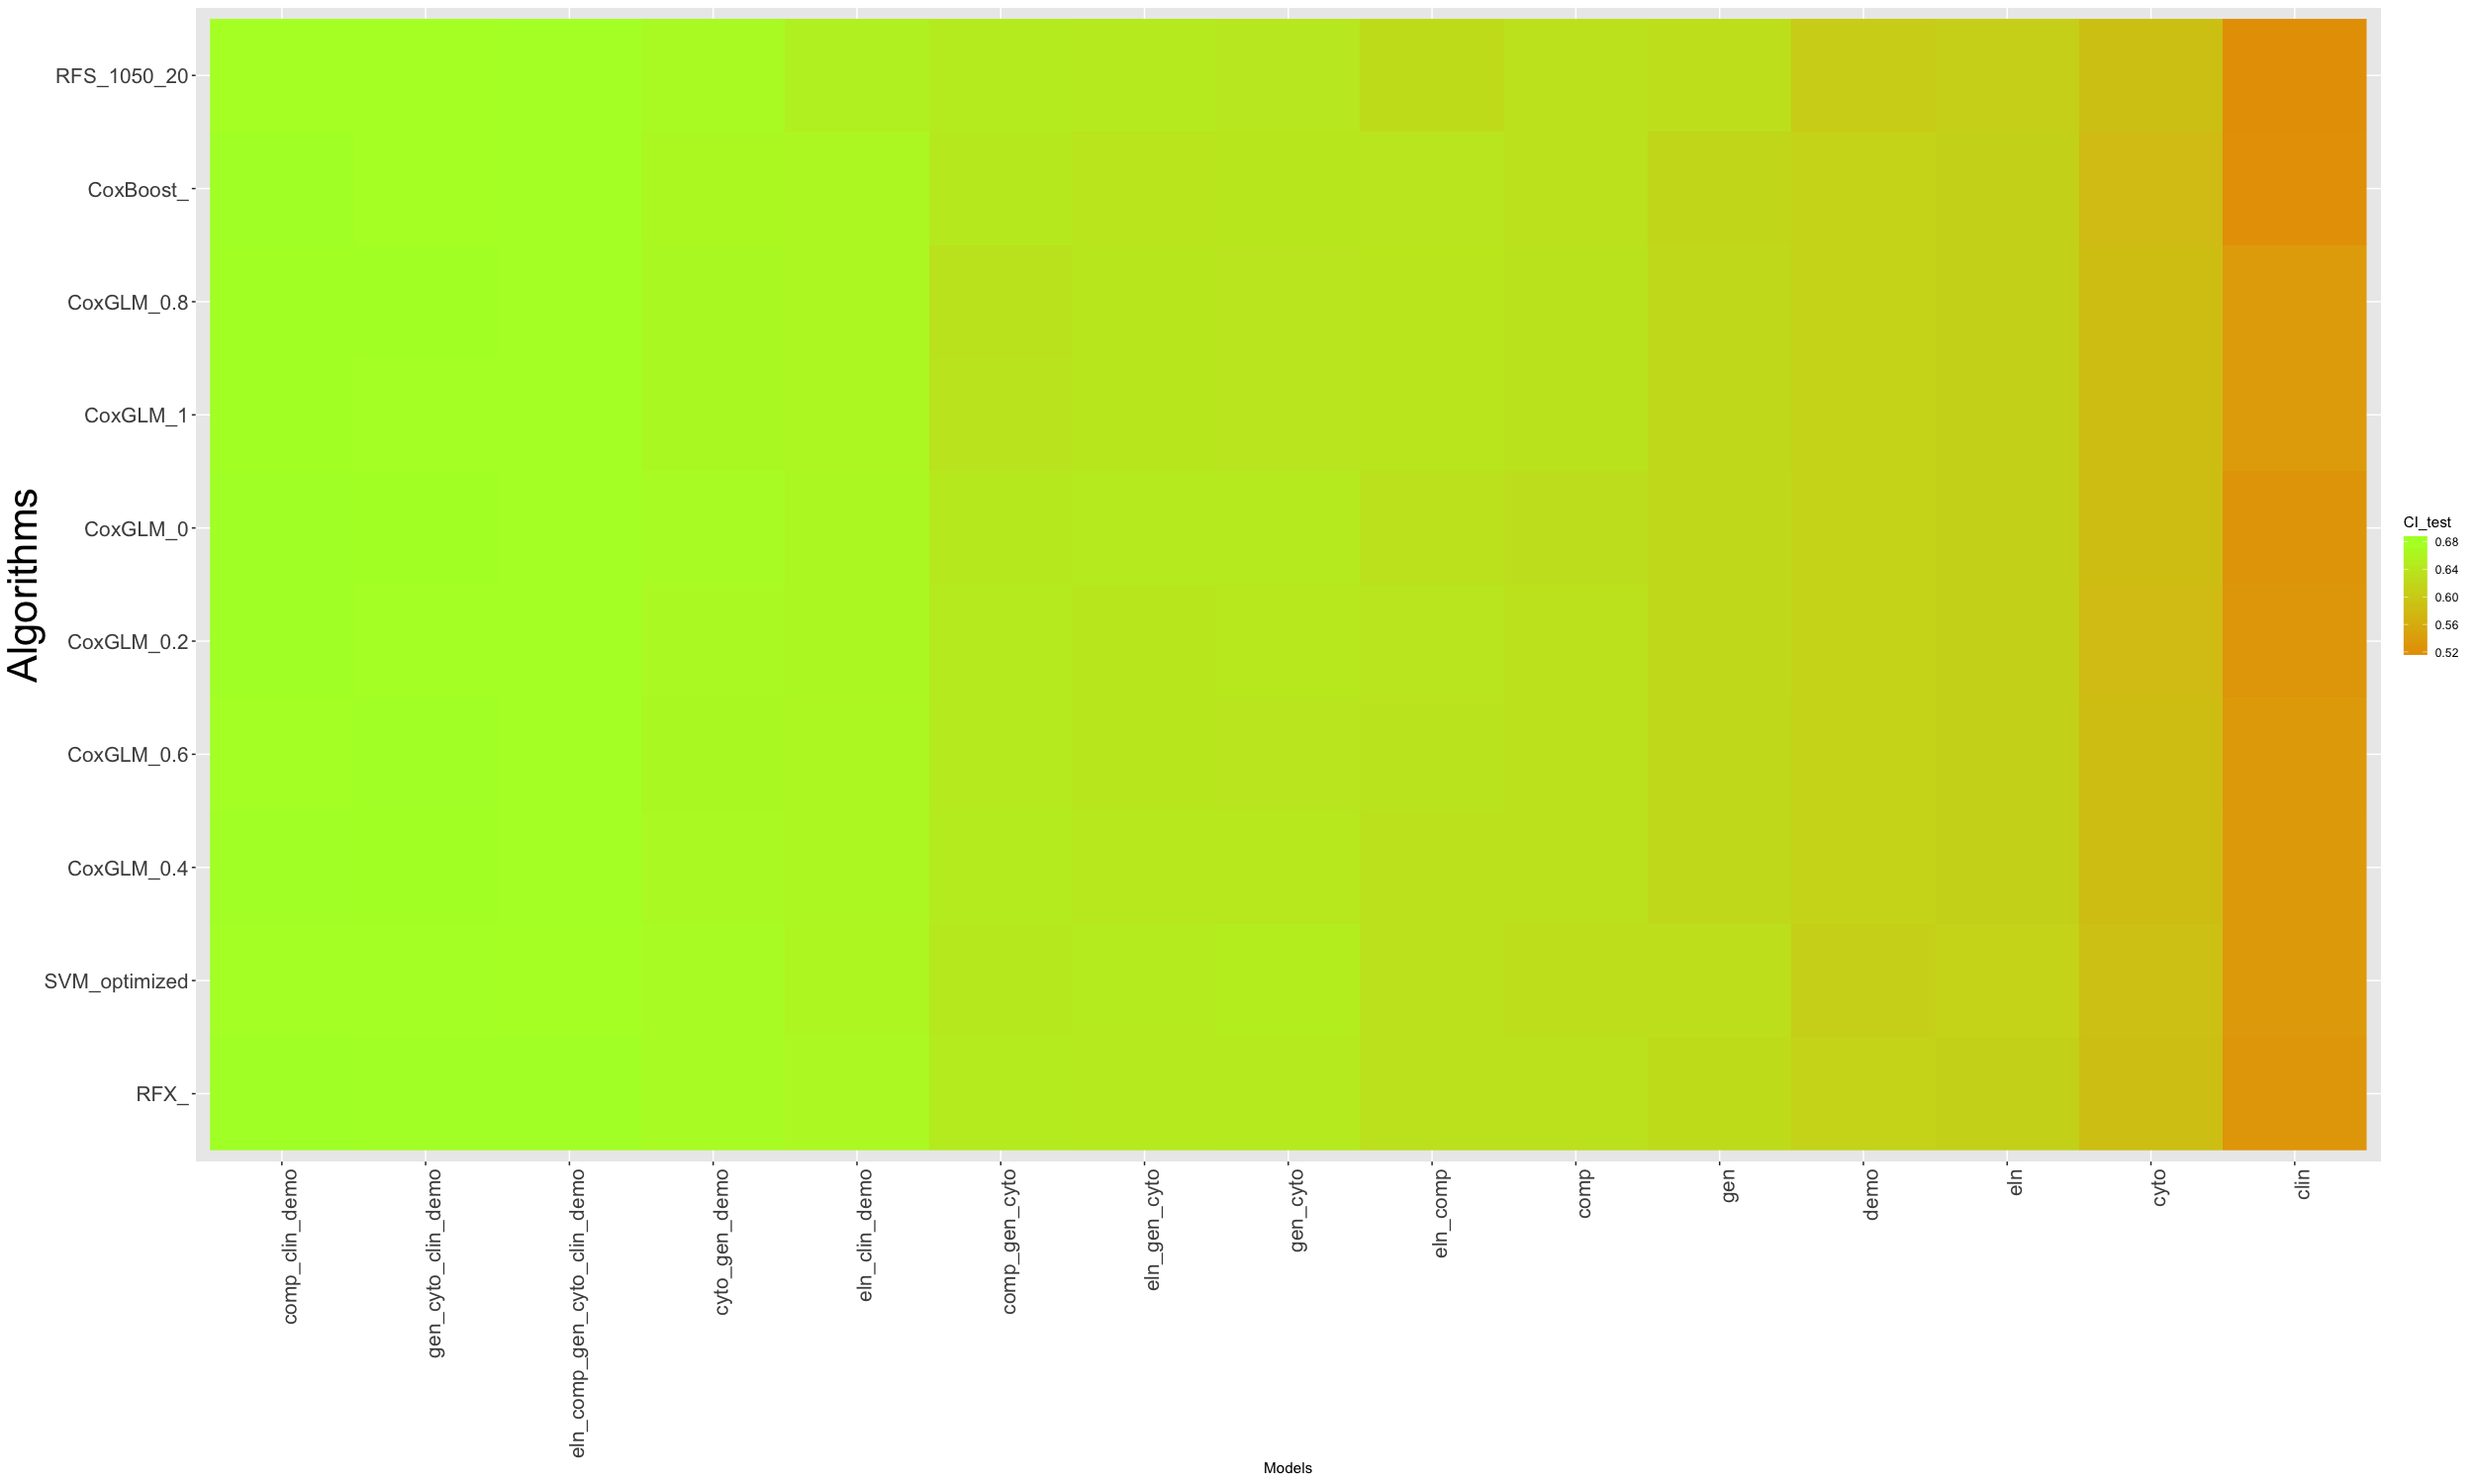

In [33]:
set_notebook_plot_size(25,15)
#nrow = number of prognosis models 
#ncol = number of feature models
table_res <- as.data.frame(matrix(0,nrow =length(unique(df_w_all$algorithm)), ncol=length(model_medians$model)))
colnames(table_res)<-levels(df_w_all$model)
rownames(table_res)<-levels(df_w_all$algorithm)

for(model in colnames(table_res)){
    for(algo in rownames(table_res)){
        table_res[algo,model]<-median(df_w_all$CI_test[df_w_all$model==model & df_w_all$algorithm==algo])
    }
}
row_names <-rownames(table_res)
table_res$algo<-rownames(table_res)
rownames(table_res)<-NULL
table_res<-melt(table_res,id='algo')
colnames(table_res)<-c('algo','model','CI_test')
table_res$algo<-factor(table_res$algo,levels=row_names)
table_res$model<-factor(table_res$model)

ggplot(table_res, aes(x=reorder(model,-CI_test), reorder(algo,-CI_test))) +
    geom_raster(aes(fill = CI_test), show.legend = TRUE) +
    scale_fill_gradient(low="#e79f00", high="greenyellow") +
    tilt_x_label(30) +
    ylab("Algorithms") +
    xlab("Models")+
    theme(axis.text.x=element_text(size=15,angle=90),axis.title.y =element_text(size=30),axis.text.y=element_text(size=15))


# Model Performance Evaluation

# 1) By Model

Warning message:
“Removed 29 rows containing non-finite values (stat_boxplot).”

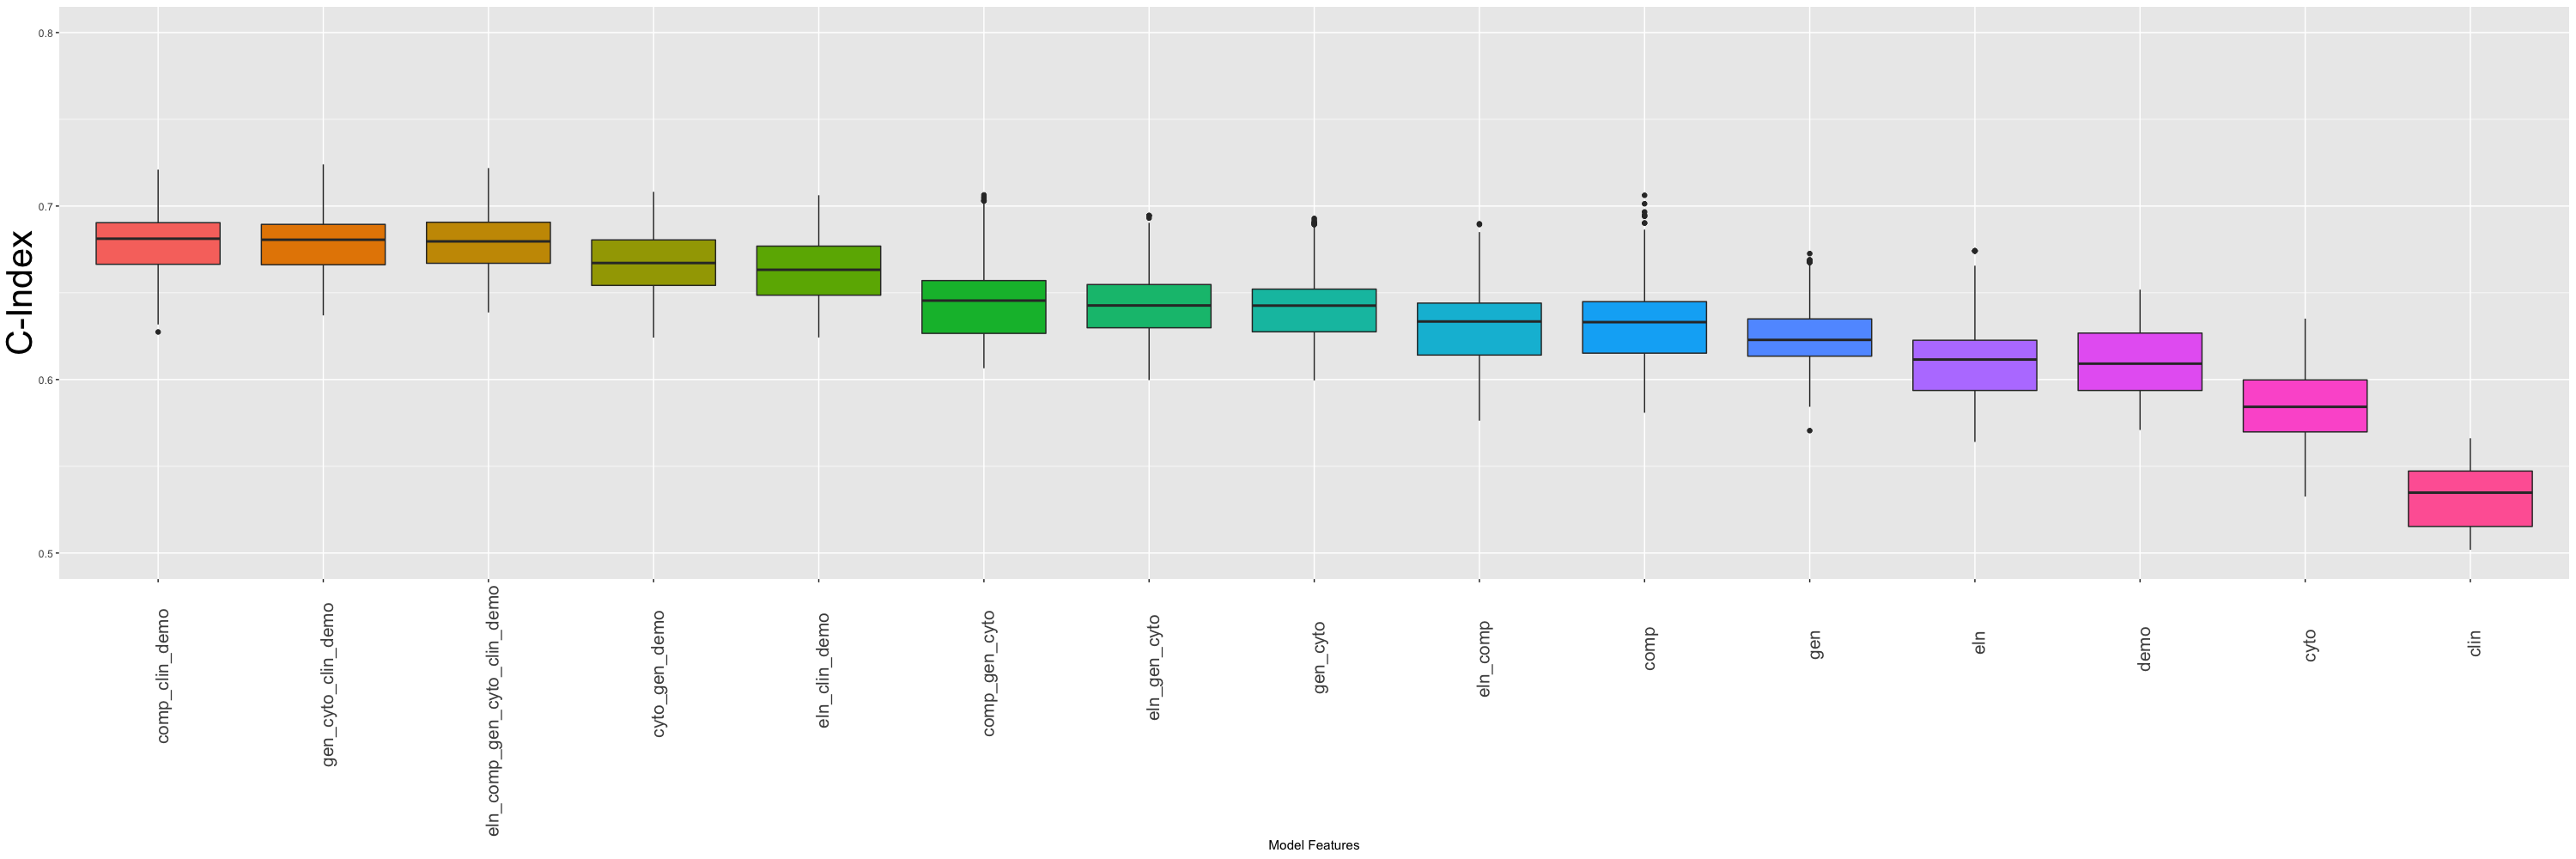

In [34]:
set_notebook_plot_size(30,10)
ggplot(df_w_all, aes(x=model,y=CI_test))+
geom_boxplot(aes(fill =model), notch=F)+
theme(legend.position="none",axis.title.y =element_text(size=30),axis.text.x = element_text(size=15,angle = 90, hjust = 0.8,vjust=0.8))+ylim(0.50,0.8)+xlab("Model Features")+ylab("C-Index")+labs(fill = " Model Features label")

# 2) By Algorithm

Warning message:
“Removed 29 rows containing non-finite values (stat_boxplot).”

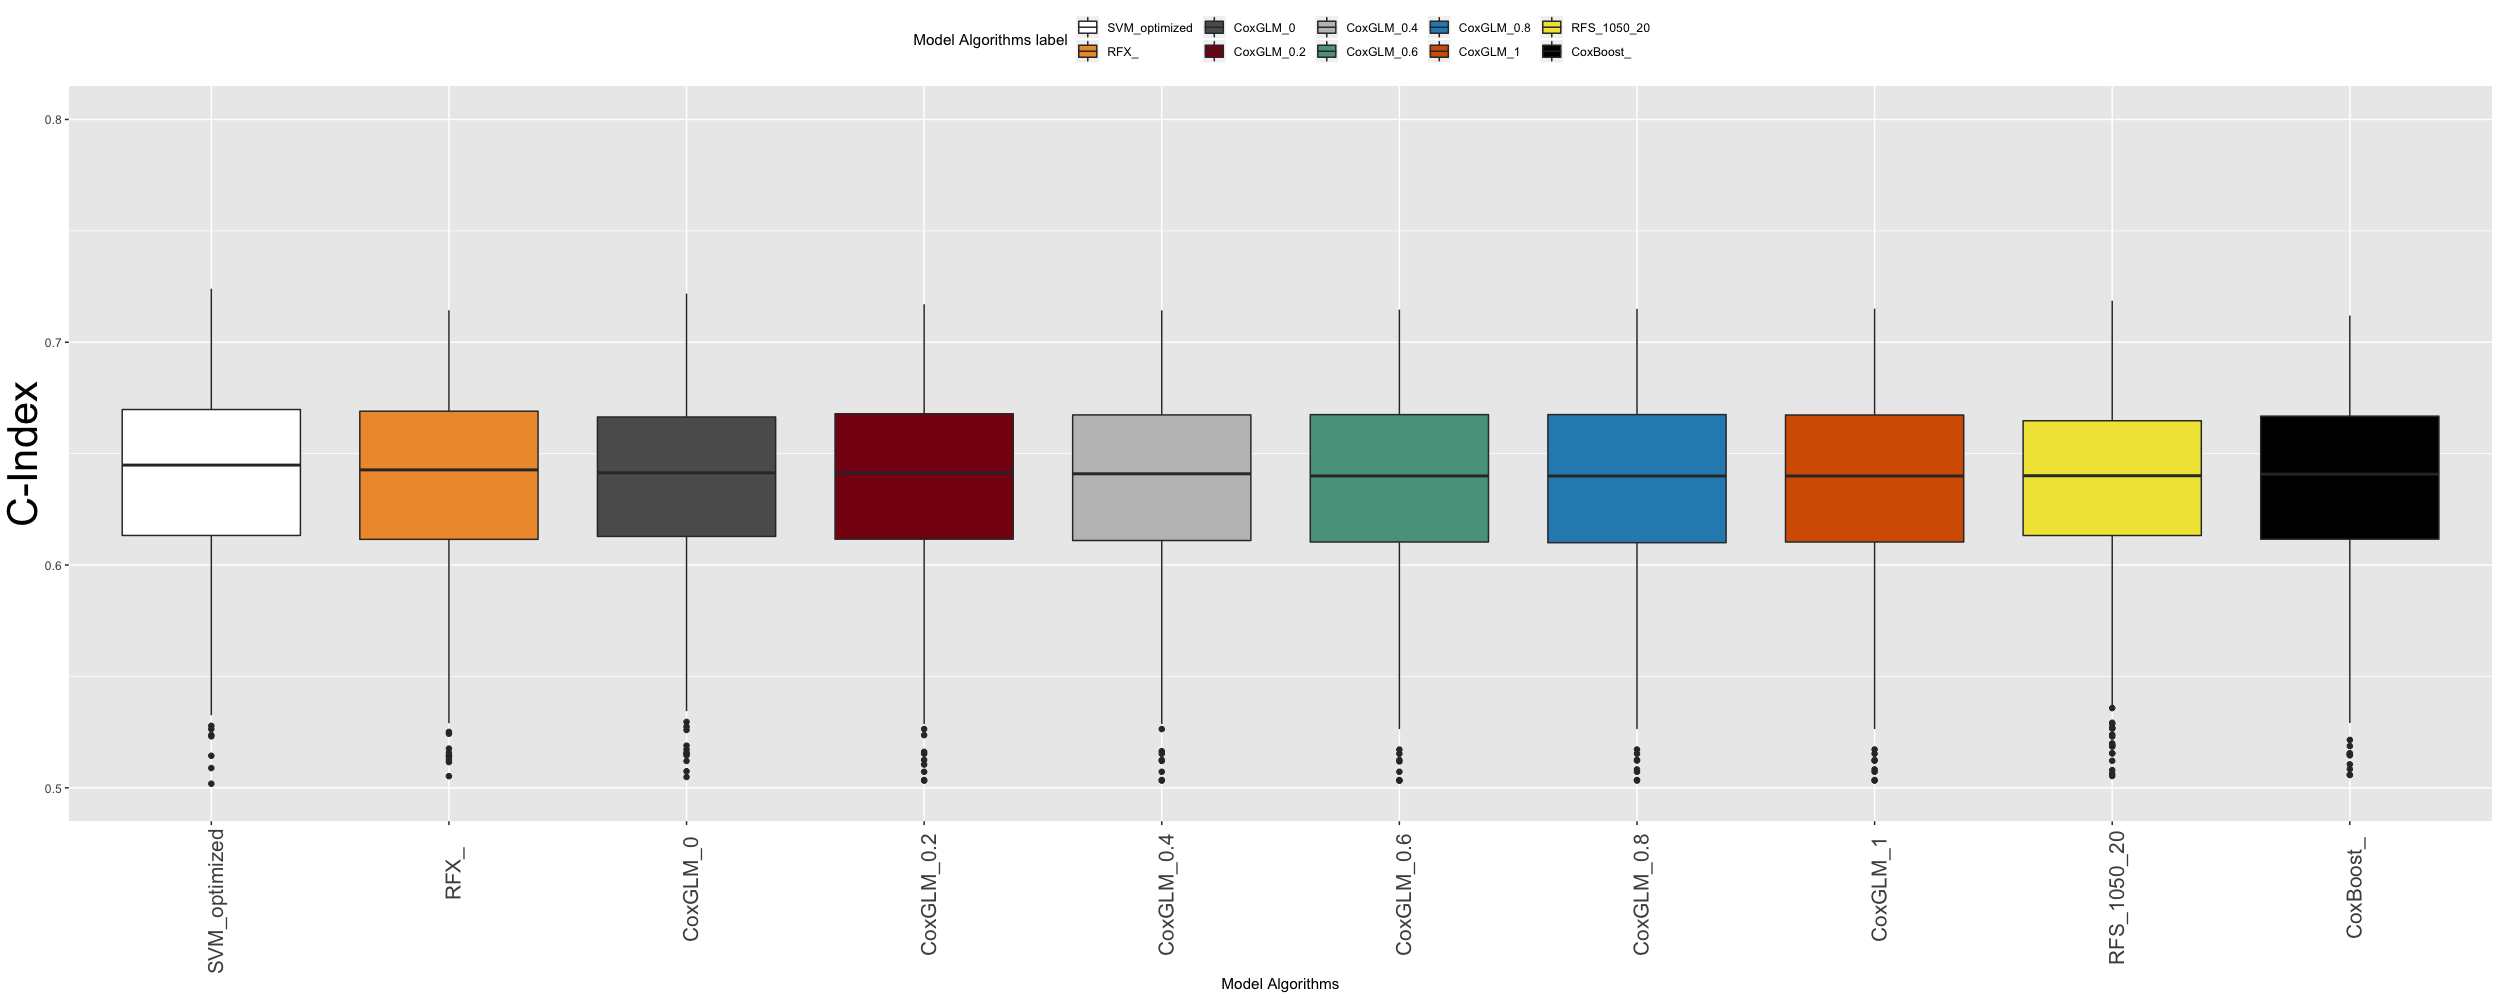

In [35]:
set_notebook_plot_size(25,10)
ggplot(df_w_all, aes(x=reorder(algorithm, -CI_test),y=CI_test))+
geom_boxplot(aes(fill =reorder(algorithm, -CI_test)), notch=F)+
theme(legend.position="top",axis.text.x = element_text(size=15,angle = 90, hjust = 0.8,vjust=0.8),axis.title.y =element_text(size=30))+ylim(0.5,0.8)+xlab("Model Algorithms")+ylab("C-Index")+labs(fill = " Model Algorithms label")+
scale_fill_manual(values=c("white","#EE9937","#5C5C5C","#870C14","#BFBFBF","#59A08B","#2b8cbe","#D55E00","#F0E442","#000000","#a6bddb","mistyrose4"))
